In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Parameters (free parameters)
# ----------------------------
L = 10.0           # domain length
N = 1000           # number of spatial grid points
dx = L / N         # spatial resolution
dt = 0.01          # time step
T = 10.0           # final time
steps = int(T / dt)

b = 2.0            # birth rate
d = 1.0            # intrinsic death rate
dprime = 0.1       # competition rate
lam = 1.0          # initial density (individuals per unit length)

sigma_m = 1.0      # std. of dispersal (birth) kernel
sigma_w = 0.1      # std. of competition kernel

# ----------------------------
# Spatial grid
# ----------------------------
# Create grid points; here x runs from -L/2 to L/2 (endpoint excluded)
x = np.linspace(-L/2, L/2, N, endpoint=False)

# ----------------------------
# Build kernels on the grid
# ----------------------------
# The dispersal (birth) kernel: Gaussian, normalized so that ∑ kappa*dx = 1.
kernel_disp = np.exp(-x**2 / (2 * sigma_m**2))
kernel_disp /= (np.sum(kernel_disp) * dx)

# The competition kernel: use a raw Gaussian with the expected amplitude.
# Note: Its amplitude scales as 1/(sqrt(2*pi)*sigma_w) so that for small sigma_w,
# the local interaction becomes strong.
kernel_comp = np.exp(-x**2 / (2 * sigma_w**2)) / (np.sqrt(2 * np.pi) * sigma_w)
# Do not renormalize kernel_comp further.

# ----------------------------
# Prepare FFT of the kernels
# ----------------------------
# For FFT-based convolution with periodic boundaries, we need to shift the kernel
# so that the "center" (x=0) is at index 0. The ifftshift does this.
kernel_disp_fft = np.fft.fft(np.fft.ifftshift(kernel_disp))
kernel_comp_fft = np.fft.fft(np.fft.ifftshift(kernel_comp))

# ----------------------------
# FFT convolution function
# ----------------------------
def fft_convolve(phi, kernel_fft):
    """
    Compute the convolution of phi with a kernel given in Fourier space.
    The convolution is computed as if the domain is periodic.
    """
    phi_fft = np.fft.fft(phi)
    conv = np.real(np.fft.ifft(phi_fft * kernel_fft)) * dx
    return conv

# ----------------------------
# Storage for multiple realizations
# ----------------------------
cor_list = []
phi_list = []

# ----------------------------
# Simulation: 100 independent runs
# ----------------------------
for run in range(100):
    # Initial condition: Poisson Point Process (PPP) with density lam.
    # For each cell, sample the number of individuals from Poisson(lam*dx)
    n_init = np.random.poisson(lam * dx, size=N)
    # Convert to density: individuals per unit length.
    phi = n_init.astype(float) / dx

    # Optionally store full time-series (here only final state is used for output)
    phi_time = np.zeros((steps, N))
    phi_time[0, :] = phi.copy()

    # Euler–Maruyama time integration
    for n in range(1, steps):
        # Compute convolutions using FFT.
        birth_conv = fft_convolve(phi, kernel_disp_fft)
        comp_conv = fft_convolve(phi, kernel_comp_fft)

        # Deterministic drift term:
        drift = b * birth_conv - d * phi - dprime * phi * comp_conv

        # Noise amplitude Gamma (variance per dt):
        Gamma = b * birth_conv + d * phi + dprime * phi * comp_conv
        Gamma = np.maximum(Gamma, 0)  # ensure nonnegative

        # Generate multiplicative Gaussian noise.
        noise = np.sqrt(Gamma) * np.random.normal(0, 1, size=N)

        # Euler–Maruyama update:
        phi = phi + dt * drift + np.sqrt(dt) * noise

        # Enforce non-negativity:
        phi = np.maximum(phi, 0)
        phi_time[n, :] = phi.copy()

    mean_density = np.mean(phi)
    print("Run", run, "Mean density at T =", T, "is", mean_density)
    phi_list.append(phi.copy())

    # Compute pair correlation (spatial autocorrelation of phi)
    phi_fluc = phi - np.mean(phi)
    corr = np.correlate(phi_fluc, phi_fluc, mode='full')
    corr = corr[corr.size // 2:]  # take only non-negative lags
    # Normalize correlation function for plotting.
    corr /= np.max(corr)
    cor_list.append(corr)

Run 0 Mean density at T = 10.0 is 9.750313680878651
Run 1 Mean density at T = 10.0 is 9.806259666185174
Run 2 Mean density at T = 10.0 is 10.313905767715257
Run 3 Mean density at T = 10.0 is 9.950883828444171
Run 4 Mean density at T = 10.0 is 9.716713430580711
Run 5 Mean density at T = 10.0 is 9.5060943542928
Run 6 Mean density at T = 10.0 is 9.72216919162063
Run 7 Mean density at T = 10.0 is 9.496405391011095
Run 8 Mean density at T = 10.0 is 9.956790034959312
Run 9 Mean density at T = 10.0 is 9.814295221088818
Run 10 Mean density at T = 10.0 is 9.990001675815009
Run 11 Mean density at T = 10.0 is 10.269612456148076
Run 12 Mean density at T = 10.0 is 9.792383701266733
Run 13 Mean density at T = 10.0 is 9.955338709727789
Run 14 Mean density at T = 10.0 is 9.895545018920405
Run 15 Mean density at T = 10.0 is 9.892385281793057
Run 16 Mean density at T = 10.0 is 9.793592414126286
Run 17 Mean density at T = 10.0 is 9.992239885078988
Run 18 Mean density at T = 10.0 is 9.942833708632632
Run 

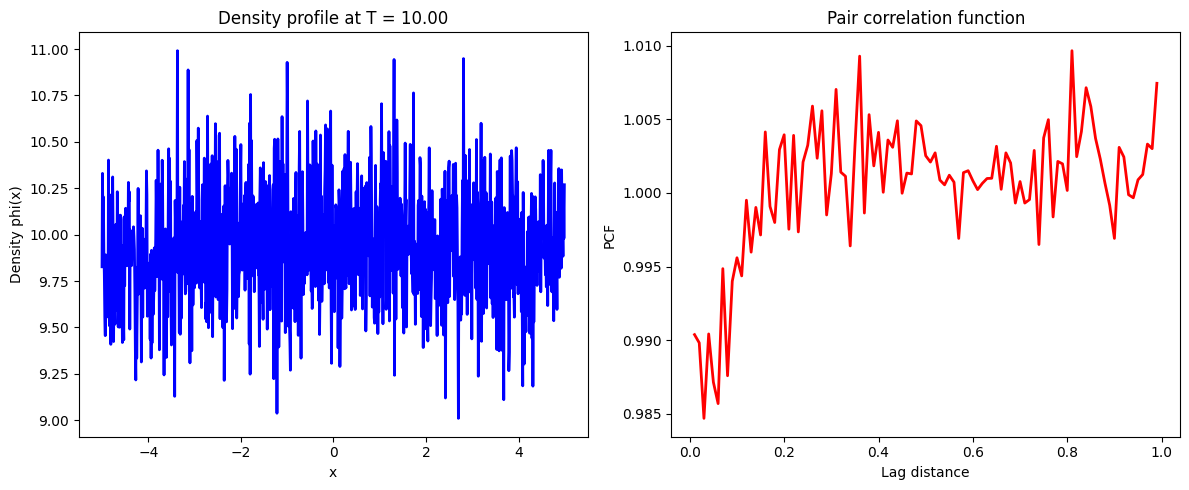

In [2]:
corr_mean = np.mean(np.array(cor_list),axis=0)
lags = np.arange(0, len(corr_mean)) * dx
phi_mean = np.mean(np.array(phi_list),axis=0)
# ----------------------------
# Plotting results
# ----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x, phi_mean, 'b-', lw=2)
plt.xlabel('x'); plt.ylabel('Density phi(x)')
plt.title('Density profile at T = {:.2f}'.format(T))

plt.subplot(1,2,2)
plt.plot(lags[1:100], corr_mean[1:100]+1, 'r-', lw=2)
plt.xlabel('Lag distance'); plt.ylabel('PCF')
plt.title('Pair correlation function')
plt.tight_layout()
plt.show()


In [3]:
np.mean(phi_mean)

np.float64(9.944303821391255)